In [2]:
import cv2
import pandas as pd
import math
import numpy as np
import sympy as sp
from google.colab.patches import cv2_imshow
from tabulate import tabulate

from IPython.display import display, Latex
sp.init_printing()

## Utility Functions

In [3]:
def pprint_df(dframe):
    print(tabulate(dframe, headers='keys', tablefmt='psql', showindex=True))

def clamp(min_v, max_v, val):
  return min(max(val, min_v), max_v)

def r(x, i=2):
    return str(round(x, i))

def calc_intensity(red, green, blue):
    return round((blue + green + red) / 3)

def calc_saturation(red, green, blue):
    minimum = min(red, green, blue)
    return round((1 - (3 / (red + green + blue + 0.001) * minimum))*255)
    
def calc_hue(red, green, blue):
    minv = min(red, green, blue)
    maxv = max(red, green, blue)
    if minv == maxv:
        return 0
    hue = 0
    if maxv == red:
        hue = (green - blue) / (maxv - minv)
    elif maxv == green:
        hue = 2 + (blue - red) / (maxv - minv)
    else:
        hue = 4 + (red - green) / (maxv - minv)
    hue = hue * 60;
    hue = hue + 360 if hue < 0 else hue;
    return round(hue)

def rgb_to_hsi(R, G, B):
  H = list(map(lambda x: calc_hue(R[x], G[x], B[x]), range(len(R))))
  S = list(map(lambda x: calc_saturation(R[x], G[x], B[x]), range(len(R))))
  I = list(map(lambda x: calc_intensity(R[x], G[x], B[x]), range(len(R))))
  return (H, S, I)

def hsi_to_rgb(H, S, I):
  def calc_rgb(hsi):
    h, s, i = hsi
    rad = math.pi / 180
    s = s/255
    i = i/255
    r, g, b = 0, 0, 0
    if h >= 0 and h < 120:
      r = i * (1 + ((s * math.cos(h * rad)) / math.cos((60 - h) * rad)))
      b = i * (1 - s)
      g = i * 3 - (r + b)
    elif h >= 120 and h < 240:
      h = h - 120
      g = i * (1 + ((s * math.cos(h * rad)) / math.cos((60 - h) * rad)))
      r = i * (1 - s)
      b = i * 3 - (r + g)
    else:
      h = h - 240
      b = i * (1 + ((s * math.cos(h * rad)) / math.cos((60 - h) * rad)))
      g = i * (1 - s)
      r = i * 3 - (b + g)
    return [round(clamp(0, 1, x) * 255) for x in (r, g, b)]

  return list(map(calc_rgb, list(zip(H, S, I))))

def calculate_hist(plane, L):
  hist = np.bincount(plane)
  pdf = hist / L
  cdf = np.cumsum(pdf)
  lookup = cdf * bit_rr

  df = pd.DataFrame({
      'count': hist.flatten(),
      'pdf': pdf.flatten(),
      'cdf': cdf.flatten(),
      'lookup': [clamp(0, 255, x) for x in lookup.flatten()]
      })
  df = df[df['count'] != 0]
  return df

def rescale_range(range, s_min, s_max):
  r_min = min(range)
  r_max = max(range)
  return list(map(lambda r:round(((((s_max - s_min)/(r_max - r_min)))*(r-r_min)+ s_min)), range))

# Range Scaling

In [ ]:
rescale_range([0, 10, 20, 30, 80, 100, 255], 175, 255)

[175, 178, 181, 184, 200, 206, 255]

# Dilation & Erosion

In [4]:
img = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0],
    [0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
    [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0],
    [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
], np.uint8)

kernel = np.array([
      [1, 1, 1],
      [1, 1, 1],
      [1, 1, 1]
], np.uint8)

img_dilation = cv2.dilate(img, kernel, iterations=1)
print('Dilated:')
pprint_df(pd.DataFrame(img_dilation))

img_erosion = cv2.erode(img, kernel, iterations=1)
print('\nEroded:')
pprint_df(pd.DataFrame(img_erosion))

Dilated:
+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+------+------+------+
|    |   0 |   1 |   2 |   3 |   4 |   5 |   6 |   7 |   8 |   9 |   10 |   11 |   12 |   13 |
|----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+------+------+------|
|  0 |   1 |   1 |   1 |   1 |   1 |   1 |   1 |   1 |   1 |   1 |    1 |    1 |    1 |    1 |
|  1 |   1 |   1 |   1 |   1 |   1 |   1 |   1 |   1 |   1 |   1 |    1 |    1 |    1 |    1 |
|  2 |   1 |   1 |   1 |   1 |   1 |   1 |   1 |   1 |   1 |   1 |    1 |    1 |    1 |    1 |
|  3 |   1 |   1 |   1 |   1 |   1 |   1 |   1 |   1 |   1 |   1 |    1 |    1 |    1 |    1 |
|  4 |   1 |   1 |   1 |   1 |   1 |   1 |   1 |   1 |   1 |   1 |    1 |    1 |    1 |    1 |
|  5 |   1 |   1 |   1 |   1 |   1 |   1 |   1 |   1 |   1 |   1 |    1 |    1 |    1 |    1 |
|  6 |   1 |   1 |   1 |   1 |   1 |   1 |   1 |   1 |   1 |   1 |    1 |    1 |    1 |    1 |
+----+-----+-----+-----+-----+-----+-----

# Internal & External Boundaries

In [ ]:
img = np.array([
    [0, 0, 0, 0, 0],
    [0, 1, 1, 1, 0],
    [0, 1, 1, 1, 0],
    [0, 1, 1, 1, 0],
    [0, 0, 0, 0, 0],
], np.uint8)

kernel = np.array([
      [1, 1, 1],
      [1, 1, 1],
      [1, 1, 1]
], np.uint8)

img_external = (cv2.dilate(img, kernel, iterations=1) - img)
print('External:')
pprint_df(pd.DataFrame(img_external))

img_internal = (img - cv2.erode(img, kernel, iterations=1))
print('\nInternal:')
pprint_df(pd.DataFrame(img_internal))

External:
+----+-----+-----+-----+-----+-----+
|    |   0 |   1 |   2 |   3 |   4 |
|----+-----+-----+-----+-----+-----|
|  0 |   1 |   1 |   1 |   1 |   1 |
|  1 |   1 |   0 |   0 |   0 |   1 |
|  2 |   1 |   0 |   0 |   0 |   1 |
|  3 |   1 |   0 |   0 |   0 |   1 |
|  4 |   1 |   1 |   1 |   1 |   1 |
+----+-----+-----+-----+-----+-----+

Internal:
+----+-----+-----+-----+-----+-----+
|    |   0 |   1 |   2 |   3 |   4 |
|----+-----+-----+-----+-----+-----|
|  0 |   0 |   0 |   0 |   0 |   0 |
|  1 |   0 |   1 |   1 |   1 |   0 |
|  2 |   0 |   1 |   0 |   1 |   0 |
|  3 |   0 |   1 |   1 |   1 |   0 |
|  4 |   0 |   0 |   0 |   0 |   0 |
+----+-----+-----+-----+-----+-----+


# Histogram Equalization 

In [5]:
img = np.array([
    [8, 20, 64, 128],
    [31, 64, 12, 58],
    [200, 147, 20, 25],
    [20, 128, 80, 100]
], np.uint8)

size = img.shape 

bit_rate = 8;
bit_rr = 2**bit_rate
print('Range 0 -', bit_rr)

hist = cv2.calcHist([img], [0], None, [bit_rr], [0,bit_rr]) 
pdf = hist / (size[0] * size[1])
cdf = np.cumsum(pdf)
lookup = cdf * bit_rr

df = pd.DataFrame({
    'count': hist.flatten(),
    'pdf': pdf.flatten(),
    'cdf': cdf.flatten(),
    'lookup': lookup.flatten()
    })
df = df[df['count'] != 0]
pprint_df(df)

newImg = np.zeros(size)
for i in range(size[0]):
  for j in range(size[1]):
    newImg[i][j] = lookup[img[i][j]]

print('\nnew Image:');
pprint_df(newImg)

Range 0 - 256
+-----+---------+--------+--------+----------+
|     |   count |    pdf |    cdf |   lookup |
|-----+---------+--------+--------+----------|
|   8 |       1 | 0.0625 | 0.0625 |       16 |
|  12 |       1 | 0.0625 | 0.125  |       32 |
|  20 |       3 | 0.1875 | 0.3125 |       80 |
|  25 |       1 | 0.0625 | 0.375  |       96 |
|  31 |       1 | 0.0625 | 0.4375 |      112 |
|  58 |       1 | 0.0625 | 0.5    |      128 |
|  64 |       2 | 0.125  | 0.625  |      160 |
|  80 |       1 | 0.0625 | 0.6875 |      176 |
| 100 |       1 | 0.0625 | 0.75   |      192 |
| 128 |       2 | 0.125  | 0.875  |      224 |
| 147 |       1 | 0.0625 | 0.9375 |      240 |
| 200 |       1 | 0.0625 | 1      |      256 |
+-----+---------+--------+--------+----------+

new Image:
+----+-----+-----+-----+-----+
|    |   0 |   1 |   2 |   3 |
|----+-----+-----+-----+-----|
|  0 |  16 |  80 | 160 | 224 |
|  1 | 112 | 160 |  32 | 128 |
|  2 | 256 | 240 |  80 |  96 |
|  3 |  80 | 224 | 176 | 192 |
+----

# Colored Image Histogram Equalization

In [ ]:
# RGB Regions
regions = np.array([
    [250, 200, 150],
    [120, 140, 250],
    [20, 50, 20],
    [100, 50, 200]
])

# per plane
bit_rate = 8;
bit_rr = 2**bit_rate

R, G, B = list(zip(*regions))

## Equalization in RGB Space

In [ ]:
print('R Plane: ')
r_df = calculate_hist(R, len(regions))
pprint_df(r_df)

print('\nG Plane: ')
g_df= calculate_hist(G, len(regions))
pprint_df(g_df)

print('\nB Plane: ')
b_df = calculate_hist(B, len(regions))
pprint_df(b_df)

newR = list(map(lambda x: r_df.loc[[x]]['lookup'].to_numpy()[0], R))
newG = list(map(lambda x: g_df.loc[[x]]['lookup'].to_numpy()[0], G))
newB = list(map(lambda x: b_df.loc[[x]]['lookup'].to_numpy()[0], B))
print('\nRGB Equalized Regions:')
print(np.vstack(list(zip(newR, newG, newB))))

R Plane: 
+-----+---------+-------+-------+----------+
|     |   count |   pdf |   cdf |   lookup |
|-----+---------+-------+-------+----------|
|  20 |       1 |  0.25 |  0.25 |       64 |
| 100 |       1 |  0.25 |  0.5  |      128 |
| 120 |       1 |  0.25 |  0.75 |      192 |
| 250 |       1 |  0.25 |  1    |      255 |
+-----+---------+-------+-------+----------+

G Plane: 
+-----+---------+-------+-------+----------+
|     |   count |   pdf |   cdf |   lookup |
|-----+---------+-------+-------+----------|
|  50 |       2 |  0.5  |  0.5  |      128 |
| 140 |       1 |  0.25 |  0.75 |      192 |
| 200 |       1 |  0.25 |  1    |      255 |
+-----+---------+-------+-------+----------+

B Plane: 
+-----+---------+-------+-------+----------+
|     |   count |   pdf |   cdf |   lookup |
|-----+---------+-------+-------+----------|
|  20 |       1 |  0.25 |  0.25 |       64 |
| 150 |       1 |  0.25 |  0.5  |      128 |
| 200 |       1 |  0.25 |  0.75 |      192 |
| 250 |       1 |  0.25

## Equalization in HSI

In [ ]:
print('RGB values:')
print(np.vstack(regions))

# HSI
H, S, I = rgb_to_hsi(R, G, B)
print('\nRGB to HSI:')
print(np.vstack(list(zip(H, S, I))))

# equalize Intensity plane
hist = calculate_hist(I, len(regions))
print('\nEqualize Intensity: ')
pprint_df(hist)

newI = list(map(lambda x: hist.loc[[x]]['lookup'].to_numpy()[0], I))
print('\nNew Regions in HSI:')
print(np.vstack(list(zip(H, S, newI))))

print('\nNew Region in RGB:')
print(np.vstack(hsi_to_rgb(H, S, newI)))

RGB values:
[[250 200 150]
 [120 140 250]
 [ 20  50  20]
 [100  50 200]]

RGB to HSI:
[[ 30  64 200]
 [231  75 170]
 [120  85  30]
 [260 146 117]]

Equalize Intensity: 
+-----+---------+-------+-------+----------+
|     |   count |   pdf |   cdf |   lookup |
|-----+---------+-------+-------+----------|
|  30 |       1 |  0.25 |  0.25 |       64 |
| 117 |       1 |  0.25 |  0.5  |      128 |
| 170 |       1 |  0.25 |  0.75 |      192 |
| 200 |       1 |  0.25 |  1    |      255 |
+-----+---------+-------+-------+----------+

New Regions in HSI:
[[ 30.  64. 255.]
 [231.  75. 192.]
 [120.  85.  64.]
 [260. 146. 128.]]

New Region in RGB:
[[255 255 191]
 [136 160 255]
 [ 43 107  43]
 [111  55 218]]


# Nearest Neighbour Interplotation

In [ ]:
def nni(image, point):
  max_x = round(point[0])
  max_y = round(point[1])

  print(f"x: {max_x}, y: {max_y}")
  return image[max_x, max_y]


In [ ]:
img = np.array([
    [10, 2, 3],
    [4, 7, 3],
    [2, 2, 1],
], np.uint8)

# NOTE: convert matlab index to python index (ie python index starts from 0 inseat of 1)
val = nni(img, (1.6, 1.7))
print(f'val: {val}')

x: 2, y: 2
val: 1


# Bilinear Interplotaion

In [ ]:
def bli(img, point):
  point = point[1], point[0]
  x = math.floor(point[0])
  y = math.floor(point[1])

  x_offset = point[0] - x
  y_offset = point[1] - y

  print(f'{img[x, y]}  {img[x, y+1]}')
  print(f'{img[x+1, y]}  {img[x+1, y+1]}')

  ix1 = (1-x_offset) * img[x, y] + (x_offset) * img[x, y+1]
  ix2 = (1-x_offset) * img[x+1, y] + (x_offset) * img[x+1, y+1]
  p = y_offset * ix2 + (1-y_offset) * ix1

  print("")
  display(Latex(f'I_{{({x}, {point[1]})}} = \\frac{{{x+1} - {point[0]}}}{{{x+1} - {x}}} \\cdotp {img[x, y]} + \\frac{{{point[0]} - {x}}}{{{x+1} - {x}}} \\cdotp {img[x, y+1]} = {r(ix1)}'))
  print("")
  display(Latex(f'I_{{({x+1}, {point[1]})}} = \\frac{{{x+1} - {point[0]}}}{{{x+1} - {x}}} \\cdotp {img[x+1, y]} + \\frac{{{point[0]} - {x}}}{{{x+1} - {x}}} \\cdotp {img[x+1, y+1]} = {r(ix2)}'))
  print("")
  display(Latex(f'I_{{({point[0]}, {point[1]})}} = \\frac{{{y+1} - {point[1]}}}{{{y+1} - {y}}} \\cdotp {r(ix1)} + \\frac{{{point[1]} - {y}}}{{{y+1} - {y}}} \\cdotp {r(ix2)} = {r(p)}'))

In [ ]:
def bli2(img, point):
  x = math.floor(point[0])
  y = math.floor(point[1])

  x_offset = point[0] - x
  y_offset = point[1] - y

  print(f'{img[x, y]}  {img[x, y+1]}')
  print(f'{img[x+1, y]}  {img[x+1, y+1]}')

  print(f'= [({r(1-x_offset)} * {img[x, y]}) + ({r(x_offset)} * {img[x+1, y]})] * {r(1-y_offset)} + [({r(1-x_offset)} * {img[x, y+1]}) + ({r(x_offset)} * {img[x+1, y+1]})] * {r(y_offset)}')
  print(f'= [{r((1-x_offset) * img[x, y])} + {r((x_offset) * img[x+1, y])}] * {r(1-y_offset)} + [{r((1-x_offset) * img[x, y+1])} + {r((x_offset) * img[x+1, y+1])}] * {r(y_offset)}')
  print(f'= {r((1-x_offset) * img[x, y] + (x_offset) * img[x+1, y])} * {r(1-y_offset)} + {r((1-x_offset) * img[x, y+1] + (x_offset) * img[x+1, y+1])} * {r(y_offset)}')

  print(f'= {r((((1-x_offset) * img[x, y] + (x_offset) * img[x+1, y]) * (1-y_offset)) + (((1-x_offset) * img[x, y+1] + (x_offset) * img[x+1, y+1]) * (y_offset)))}')

In [ ]:
img = np.array([
    [91, 210, 3],
    [162, 7, 3],
    [2, 2, 1],
], np.uint8)

# NOTE: convert matlab index to python index (ie python index starts from 0 inseat of 1)
bli(img, (1.6, 1.7))
# bli(img, (0.2, 0.5))
# bli(img, (0.5, 0.2))

# bli2(img, (0.2, 0.5))
bli2(img, (1.6, 1.7))

7  3
2  1



<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

7  3
2  1
= [(0.4 * 7) + (0.6 * 2)] * 0.3 + [(0.4 * 3) + (0.6 * 1)] * 0.7
= [2.8 + 1.2] * 0.3 + [1.2 + 0.6] * 0.7
= 4.0 * 0.3 + 1.8 * 0.7
= 2.46


# Color Models

## RGB to HSI

In [ ]:
def rgb2hsi(r, g, b):
  re, ge, be = sp.symbols('r g b')

  ie = sp.simplify("1/3") * (re + ge + be)
  se = sp.simplify("1") - 1/ie * min(r, g, b)
  te = sp.acos((1/2*((re-ge) + (re-be))) / sp.sqrt((re- ge)**2 + (re-be) * (ge-be)))

  display(sp.Eq(sp.symbols('I'), ie))
  print("")
  display(sp.Eq(sp.symbols('S'), se))
  print("")
  display(sp.Eq(sp.symbols('theta'), te))

  i = sp.lambdify((re, ge, be), ie)(r, g, b)
  s = sp.lambdify((re, ge, be), se)(r, g, b)
  t = sp.lambdify((re, ge, be), te)(r, g, b)
  t = 0 if np.isnan(t) else t
  h = t if b <= g else 2*math.pi - t

  display(sp.Eq(sp.symbols('theta'), t))
  display(sp.Eq(sp.symbols('H'), h))
  display(sp.Eq(sp.symbols('S'), s))
  display(sp.Eq(sp.symbols('I'), i))

  return h * 180 / math.pi, s*255, i

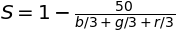

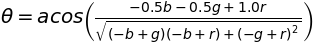


259.0 146.0 117.0


In [ ]:
h, s, i = rgb2hsi(100, 50, 200)
print("")
print(r(h, 0), r(s, 0), r(i, 0))

## HSI to RGB

In [ ]:
def hsi2rgb(h, s, i):
  he, se, ie = sp.symbols('H S I')
  rs, gs, bs = sp.symbols('R G B')

  h = h * math.pi / 180
  print(h, s, i)

  if h >= 0 and h < 2 * math.pi / 3:
    display("h >= 0 and h < 120")

    re = ie * (1 + ((se * sp.cos(he)) / sp.cos(sp.pi/3 - he)))
    be = ie * (1 - se)
    ge = 3 * ie - (rs + bs)

    r = sp.lambdify((he, se, ie), re)(h, s, i)
    b = sp.lambdify((he, se, ie), be)(h, s, i)
    g = sp.lambdify((rs, bs, ie), ge)(r, b, i)

  elif h >= 2 * math.pi / 3 and h < 4 * math.pi / 3:
    display("h >= 120 and h < 240")
    h = h - 2 * math.pi / 3

    re = ie * (1 - se)
    ge = ie * (1 + ((se * sp.cos(he)) / sp.cos(sp.pi/3 - he)))
    be = 3 * ie - (rs + gs)

    r = sp.lambdify((he, se, ie), re)(h, s, i)
    g = sp.lambdify((he, se, ie), ge)(h, s, i)
    b = sp.lambdify((rs, gs, ie), be)(r, g, i)
  else:
    display("h >= 240 and h < 360")
    h = h - 4 * math.pi / 3

    be = ie * (1 + ((se * sp.cos(he)) / sp.cos(sp.pi/3 - he)))
    ge = ie * (1 - se)
    re = 3 * ie - (gs + bs)

    b = sp.lambdify((he, se, ie), be)(h, s, i)
    g = sp.lambdify((he, se, ie), ge)(h, s, i)
    r = sp.lambdify((gs, bs, ie), re)(g, b, i)

  display(sp.Eq(rs, re))
  print("")
  display(sp.Eq(gs, ge))
  print("")
  display(sp.Eq(bs, be))
  print("")

  display(sp.Eq(rs, r ))
  print("")
  display(sp.Eq(gs, g ))
  print("")
  display(sp.Eq(bs, b))
  print("")
  
  return [round(clamp(0, 1, x) * 255) for x in (r, g, b)]

4.537856055185257 0.5725490196078431 0.4588235294117647


'h >= 240 and h < 360'

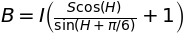

In [ ]:
hsi2rgb(260, 146/255, 117/255)